# VQE on the 2D Transverse-Field Ising Model via Pauli Propagation

This tutorial demonstrates a full **Variational Quantum Eigensolver (VQE)** workflow using `pprop` on a non-trivial many-body problem: the 2D transverse-field Ising model on a $5 \times 5$ lattice with open boundary conditions.

VQE minimises the energy expectation value $\langle H \rangle$ over a parametrized ansatz $U(\boldsymbol{\theta})$:

$$E(\boldsymbol{\theta}) = \langle 0 | U^\dagger(\boldsymbol{\theta})\, H\, U(\boldsymbol{\theta}) | 0 \rangle$$

With `pprop`, $E(\boldsymbol{\theta})$ is computed as a closed-form trigonometric polynomial via Pauli propagation, no statevector simulation required. This makes gradient evaluation cheap even for 25 qubits.

**Key approximation:** we use truncation cutoffs `k1` (Pauli weight) and `k2` (frequency) to keep the propagated expression tractable. This introduces a controlled approximation that trades accuracy for speed.

## Step 0: Imports

In [1]:
import pennylane as qml
from pprop import Propagator
import numpy as np

/home/samonaco/Pauli-Propagator/.venv/lib/python3.12/site-packages/pennylane/operation.py:2622: PennyLaneDeprecationWarning: Observable is deprecated and will be removed in v0.43. A generic Operator class should be used instead. If defining an Operator, set the is_hermitian property to True. If checking if an Operator is Hermitian, check the is_hermitian property. 
  warnings.warn(


## Step 1: Define the Hamiltonian

The **2D transverse-field Ising model** on an $L \times L$ lattice with open boundary conditions is:

$$H(J, h) = -\frac{1}{N}\left(J\sum_{\langle i,j \rangle} Z_i Z_j + h\sum_i X_i\right)$$

where $N = L^2$ is the total number of sites, $\langle i,j \rangle$ denotes nearest-neighbour pairs (right and down neighbours only, to avoid double-counting), $J$ is the ferromagnetic coupling strength, and $h$ is the transverse field strength. The $1/N$ normalisation keeps the energy per site of order 1 regardless of system size.

We use $J = h = 1$. In 2D the critical point lies at $h/J \approx 3.04$, so this choice places the system well inside the **ferromagnetic phase** ($h \ll h_c$), where the ground state has strong $ZZ$ correlations and the transverse field acts as a perturbation.

The lattice is indexed row-major: site $(x, y)$ maps to qubit $i = x \cdot L + y$.

In [2]:
side : int = 5
J : float = 1
h : float = 1

num_qubits : int = side * side

In [3]:
def hamiltonian(side: int, J: float, h: float) -> qml.Hamiltonian:
    coeffs = []
    obs = []

    # Nearest-neighbor ZZ interactions
    for x in range(side):
        for y in range(side):
            i = x * side + y

            # Right neighbor
            if y < side - 1:
                j = x * side + (y + 1)
                coeffs.append(-J / num_qubits)
                obs.append(qml.PauliZ(i) @ qml.PauliZ(j))

            # Down neighbor
            if x < side - 1:
                j = (x + 1) * side + y
                coeffs.append(-J / num_qubits)
                obs.append(qml.PauliZ(i) @ qml.PauliZ(j))

    # Transverse-field X terms
    for i in range(num_qubits):
        coeffs.append(-h / num_qubits)
        obs.append(qml.PauliX(i))

    return qml.Hamiltonian(coeffs, obs)

The Hamiltonian in full:

$$H(J, h) = -\frac{1}{N}\left(J\sum_{\langle i,j \rangle} Z_i Z_j + h\sum_i X_i\right)$$

For our $5 \times 5$ lattice ($N = 25$), this yields $40$ nearest-neighbour $ZZ$ terms (20 horizontal + 20 vertical) and $25$ single-site $X$ terms, **65 Pauli words** in total.

The lattice connectivity for the $5 \times 5$ open boundary condition model. Each node is a qubit; edges represent $ZZ$ couplings:

<img src="./assets/ising2d.svg" width="600">

## Step 2: Define the Ansatz

We use a hardware-efficient ansatz designed to respect the 2D lattice geometry. The circuit structure is:

1. **Initial rotation layer:** RY + RX on every qubit: 50 parameters
2. **Horizontal entanglers:** two rounds of CNOT gates along rows (even columns, then odd columns), covering all horizontal nearest-neighbour pairs
3. **RX layer:** single-qubit RX on every qubit: 25 parameters
4. **Vertical entanglers:** two rounds of CNOT gates along columns (even rows, then odd rows), covering all vertical nearest-neighbour pairs
5. **RX layer:** single-qubit RX on every qubit: 25 parameters
6. **Final RY layer:** single-qubit RY on every qubit: 25 parameters

Total: **125 trainable parameters** across 25 qubits. The two-round CNOT strategy (even-then-odd) ensures every nearest-neighbour pair is entangled.

In [4]:
def circuit(params):
    index = 0

    # Initial RY and RX
    for q in range(num_qubits):
        qml.RY(params[index], wires=q)
        index += 1
        qml.RX(params[index], wires=q)
        index += 1

    # Horizontal entanglers
    for d in range(2):
        y_start = 0 if d % 2 == 0 else 1
        for x in range(side):
            for y in range(y_start, side - 1, 2):
                i = x * side + y
                j = x * side + (y + 1)
                qml.CNOT(wires=[i, j])

    # RX layer
    for q in range(num_qubits):
        qml.RX(params[index], wires=q)
        index += 1

    # Vertical entanglers
    for d in range(2):
        x_start = 0 if d % 2 == 0 else 1
        for y in range(side):
            for x in range(x_start, side - 1, 2):
                i = x * side + y
                j = (x + 1) * side + y
                qml.CNOT(wires=[i, j])

    # RX layer
    for q in range(num_qubits):
        qml.RX(params[index], wires=q)
        index += 1

    # Final RY
    for q in range(num_qubits):
        qml.RY(params[index], wires=q)
        index += 1
        
    return qml.expval(hamiltonian(side, J, h))

## Step 3: Create the Propagator with truncation

For a 25-qubit system, exact Pauli propagation would be intractable, the number of terms grows exponentially with circuit depth. We instead use two cutoffs to keep the computation feasible:

- **`k1 = 6`** (Pauli weight cutoff): discard any evolved Pauli word that acts non-trivially on more than 6 qubits. Terms with high Pauli weight tend to have small coefficients and contribute little to the expectation value, especially near the ground state.
- **`k2 = 20`** (frequency cutoff): discard any term whose trigonometric degree (total number of sin/cos factors) exceeds 20. High-frequency terms correspond to rapidly oscillating contributions that average out over the parameter landscape.

These choices are a deliberate accuracy-vs-speed trade-off and can be tuned depending on the problem.

In [5]:
prop = Propagator(circuit, k1=6, k2=20)

In [6]:
prop

Propagator
  Number of qubits : 25
  Trainable parameters : 125

We can inspect the full circuit structure using `.show()`. The 25-qubit circuit is displayed as a series of horizontal slices:

In [7]:
prop.show()

 0: ──RY(0.00)───RX(1.00)──╭●──RX(50.00)────────────╭●──RX(75.00)──RY(100.00)──────────── ···
 1: ──RY(2.00)───RX(3.00)──╰X─╭●──────────RX(51.00)─│──╭●──────────RX(76.00)───RY(101.00) ···
 2: ──RY(4.00)───RX(5.00)──╭●─╰X──────────RX(52.00)─│──│──────────╭●───────────RX(77.00)─ ···
 3: ──RY(6.00)───RX(7.00)──╰X─╭●──────────RX(53.00)─│──│──────────│───────────╭●───────── ···
 4: ──RY(8.00)───RX(9.00)─────╰X──────────RX(54.00)─│──│──────────│───────────│────────── ···
 5: ──RY(10.00)──RX(11.00)─╭●──RX(55.00)────────────╰X─│──────────│───────────│────────── ···
 6: ──RY(12.00)──RX(13.00)─╰X─╭●──────────RX(56.00)────╰X─────────│───────────│────────── ···
 7: ──RY(14.00)──RX(15.00)─╭●─╰X──────────RX(57.00)───────────────╰X──────────│────────── ···
 8: ──RY(16.00)──RX(17.00)─╰X─╭●──────────RX(58.00)───────────────────────────╰X───────── ···
 9: ──RY(18.00)──RX(19.00)────╰X──────────RX(59.00)────────────────────────────────────── ···
10: ──RY(20.00)──RX(21.00)─╭●──RX(60.00)────────────╭●──────

## Step 4: Propagate

`.propagate()` evolves the full Hamiltonian backwards through the circuit. Since the Hamiltonian is a sum of 65 Pauli words, each is propagated independently and the results are combined.

The propagation output shows the initial Hamiltonian as a `PauliDict`: note the $-1/25 \approx -0.04$ coefficient on every term from the $1/N$ normalisation.

In [8]:
prop.propagate()

Propagating (-0.0400)*Z0 Z1 + (-0.0400)*Z0 Z5 + (-0.0400)*Z1 Z2 + (-0.0400)*Z1 Z6 + (-0.0400)*Z2 Z3 + (-0.0400)*Z2 Z7 + (-0.0400)*Z3 Z4 + (-0.0400)*Z3 Z8 + (-0.0400)*Z4 Z9 + (-0.0400)*Z5 Z6 + (-0.0400)*Z5 Z10 + (-0.0400)*Z6 Z7 + (-0.0400)*Z6 Z11 + (-0.0400)*Z7 Z8 + (-0.0400)*Z7 Z12 + (-0.0400)*Z8 Z9 + (-0.0400)*Z8 Z13 + (-0.0400)*Z9 Z14 + (-0.0400)*Z10 Z11 + (-0.0400)*Z10 Z15 + (-0.0400)*Z11 Z12 + (-0.0400)*Z11 Z16 + (-0.0400)*Z12 Z13 + (-0.0400)*Z12 Z17 + (-0.0400)*Z13 Z14 + (-0.0400)*Z13 Z18 + (-0.0400)*Z14 Z19 + (-0.0400)*Z15 Z16 + (-0.0400)*Z15 Z20 + (-0.0400)*Z16 Z17 + (-0.0400)*Z16 Z21 + (-0.0400)*Z17 Z18 + (-0.0400)*Z17 Z22 + (-0.0400)*Z18 Z19 + (-0.0400)*Z18 Z23 + (-0.0400)*Z19 Z24 + (-0.0400)*Z20 Z21 + (-0.0400)*Z21 Z22 + (-0.0400)*Z22 Z23 + (-0.0400)*Z23 Z24 + (-0.0400)*X0 + (-0.0400)*X1 + (-0.0400)*X2 + (-0.0400)*X3 + (-0.0400)*X4 + (-0.0400)*X5 + (-0.0400)*X6 + (-0.0400)*X7 + (-0.0400)*X8 + (-0.0400)*X9 + (-0.0400)*X10 + (-0.0400)*X11 + (-0.0400)*X12 + (-0.0400)*X13 + (-0.0

## Step 5: Run VQE

With the propagator ready, VQE reduces to minimising a fast scalar function. We use the `adam` optimiser from `pprop.optimization`, which:
1. Calls `prop.eval_and_grad(params)` to get $E(\boldsymbol{\theta})$ and $\nabla_{\boldsymbol{\theta}} E$ analytically
2. Passes the gradient to an Adam update step via `optax`

The loss `L = lambda f: f[0]` simply selects the first (and only) observable, the Hamiltonian expectation value, as the quantity to minimise.

We run for **2000 steps** with learning rate $10^{-3}$ from a random initial point.

In [9]:
from pprop.optimization import adam

result = adam(
    L=lambda f: f[0],                  # minimise the energy expectation value
    propagator=prop,
    params_init=np.random.rand(prop.num_params),
    lr=1e-3,
    num_steps=2000
)

  step   100/2000  loss = -0.59015609
  step   200/2000  loss = -0.82286771
  step   300/2000  loss = -1.04637993
  step   400/2000  loss = -1.21871748
  step   500/2000  loss = -1.34013627
  step   600/2000  loss = -1.42176331
  step   700/2000  loss = -1.47727265
  step   800/2000  loss = -1.51657246
  step   900/2000  loss = -1.54340317
  step  1000/2000  loss = -1.56118992
  step  1100/2000  loss = -1.57375771
  step  1200/2000  loss = -1.58316466
  step  1300/2000  loss = -1.59045150
  step  1400/2000  loss = -1.59614716
  step  1500/2000  loss = -1.60037772
  step  1600/2000  loss = -1.60315886
  step  1700/2000  loss = -1.60473841
  step  1800/2000  loss = -1.60555126
  step  1900/2000  loss = -1.60596072
  step  2000/2000  loss = -1.60616996


The optimisation converges to an energy of approximately $-1.6$ per site. Note that this is a **variational upper bound** on the true ground state energy under the truncation approximation. A lower value would require `k1 = None, k2 = None` and a deeper circuit.

The result dict contains the final parameters, the converged loss, and the full loss history for plotting:

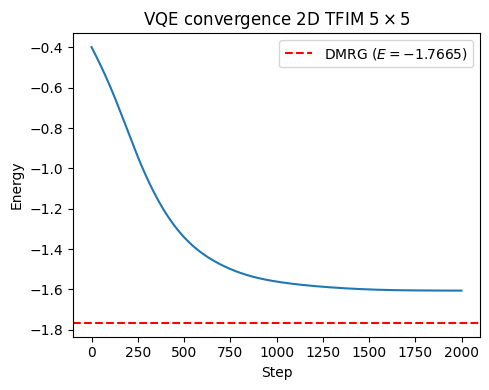

Final energy : -1.606171
DMRG energy  : -1.76649063
Gap          : 0.160319


In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(result['history'])
ax.axhline(-1.76649063, color='r', linestyle='--', label='DMRG ($E = -1.7665$)')
ax.set_xlabel('Step')
ax.set_ylabel('Energy')
ax.set_title('VQE convergence 2D TFIM $5 \\times 5$')
ax.legend()
plt.tight_layout()
plt.show()

print(f"Final energy : {result['fun']:.6f}")
print("DMRG energy  : -1.76649063")
print(f"Gap          : {result['fun'] - (-1.76649063):.6f}")